# Classification of Byzantine Seal Images

1. Mount Google Drive in Google Colab, making Drive files accessible in the notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Import required libraries and set random seeds for reproducibility

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import shutil
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## Loading and resizing data

### Restructuring the Folders

3. Reorganize images from a flat directory into class-labeled subfolders, as required by Keras `image_dataset_from_directory()` method. One file had an incorrect filename and was manually corrected by adding a missing underscore (_).

In [ ]:
def restructure_dataset(source_dir, target_dir):
    """
    Moves files from a flat structure (class__index.jpg)
    to a class-based folder structure (target_dir/class/index.jpg).
    """
    source_path = Path(source_dir)
    target_path = Path(target_dir)

    # Create target directory if it doesn't exist
    if not target_path.exists():
        os.makedirs(target_path)

    files = list(source_path.glob('*.jpg'))
    print(f"Found {len(files)} images in {source_dir}. Organizing...")

    for file_path in files:
        filename = file_path.name

        # Parse class ID from filename "<class id>__<index>.jpg"
        # Example: "01__005.jpg" -> class_id = "01"
        try:
            class_id = filename.split('__')[0]

            # Create class subdirectory
            class_dir = target_path / class_id
            os.makedirs(class_dir, exist_ok=True)

            # Copy file to new location
            shutil.copy2(file_path, class_dir / filename)

        except IndexError:
            print(f"Skipping file with bad format: {filename}")

    print(f"Finished organizing {source_dir} into {target_dir}")

In [ ]:
# --- EXECUTE RESTRUCTURING ---
current_train_dir = '/content/drive/MyDrive/TMDRA-Project/real/train'
current_test_dir = '/content/drive/MyDrive/TMDRA-Project/real/test'

new_train_dir = '/content/drive/MyDrive/TMDRA-Project/real/train_structured'
new_test_dir = '/content/drive/MyDrive/TMDRA-Project/real/test_structured'

# restructure_dataset(current_train_dir, new_train_dir)
# restructure_dataset(current_test_dir, new_test_dir)

### Loading the data

4. Images were resized to 112x112 because the crops were extracted from images of different sizes, so crops range in size from about 60x60 px and below to 180x180 px and above.

In [ ]:
# Define parameters
BATCH_SIZE = 32 # Number of images are processed together in one training step.
IMG_SIZE = (112, 112) # The target image size to which all images are resized.

5. Load images from a directory as a Keras dataset and return the training subset (90%) after a train–validation split.

In [ ]:
# Load Training Data (and split 10% for Validation)
train_ds = tf.keras.utils.image_dataset_from_directory(
    new_train_dir,
    validation_split=0.1,       # 10% for validation
    subset="training",
    seed=123,                   # Seed so train/val don't overlap
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 1610 files belonging to 24 classes.
Using 1449 files for training.


6. Load the validation dataset (10%) from the same directory using the predefined train–validation split. Due to the limited size of the dataset, 10% of the train images was set for validation purposes.

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    new_train_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 1610 files belonging to 24 classes.
Using 161 files for validation.


7. Load test images from a separate directory, resize them, and keep their original order for evaluation.

In [ ]:
# Load Test Data (Separate folder, no split needed)
test_ds = tf.keras.utils.image_dataset_from_directory(
    new_test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False # not shuffling test data so predictions match file order
)

Found 430 files belonging to 24 classes.


8. Retrieve and display the class names detected from the training dataset.

In [ ]:
class_names = train_ds.class_names
print(f"\nClasses detected: {class_names}")


Classes detected: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8', '9']


### Visualizing samples

9. Read class labels from a text file and store them in a dictionary for later use.

In [ ]:
# Create a dictionary to map class IDs to text labels
label_map = {}

# Read the file line by line
with open('/content/drive/MyDrive/TMDRA-Project/labels.txt', 'r') as f:
    for line in f:
        # Split the line into ID and Label (e.g., "10 Lambda" -> ["10", "Lambda"])
        parts = line.strip().split(' ', 1)
        if len(parts) == 2:
            # key = ID (string), value = Label Name
            label_map[parts[0]] = parts[1]

print("Label mapping loaded!")
print(f"Example: Class '10' is {label_map.get('10')}")

Label mapping loaded!
Example: Class '10' is Lambda


10. Display example images with their corresponding class IDs and text labels.

Visualizing Training Data with Greek Labels...


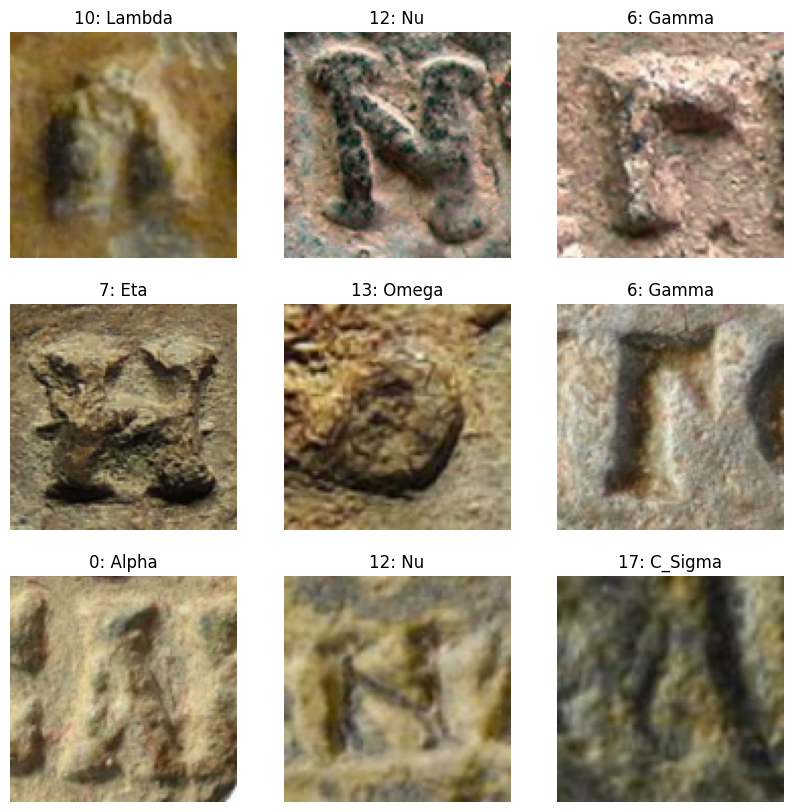

In [ ]:
def visualize_with_text_labels(dataset, class_names, mapping):
    plt.figure(figsize=(10, 10))

    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            img_array = images[i].numpy().astype("uint8")

            # 1. Get the numeric index from the batch
            idx = labels[i]
            # 2. Get the folder name (e.g., "10")
            folder_name = class_names[idx]
            # 3. Get the real name (e.g., "Lambda")
            text_label = mapping.get(folder_name, "Unknown")

            plt.imshow(img_array)
            plt.title(f"{folder_name}: {text_label}")
            plt.axis("off")
    plt.show()

# Visualize with the new labels
print("Visualizing Training Data with Greek Labels...")
visualize_with_text_labels(train_ds, class_names, label_map)

## Modeling experiments

### Phase 1: Baseline: Naive Approach

**Goal:** Establish a minimum performance benchmark.

**Architecture:** LeNet-300 (Fully Connected Network). No Convolutional layers

**Hypothesis:** "Simple fully connected network will struggle with this task because it flattens the image, destroying the spatial relationships between pixels (the shapes of the letters). Expected to see overfitting (high training accuracy, low validation accuracy)."

**Implementation:**
* Layers: Flatten $\to$ Dense(300) $\to$ Dense(100) $\to$ Output.
* Augmentation: None
* Regularization: None

#### Defining the Baseline Model

In [ ]:
def build_baseline_model(num_classes):
    model = models.Sequential([
        # Input Layer: Used 112x112
        layers.Input(shape=(112, 112, 3)),

        # Preprocessing: Scale pixel values to [0,1]
        layers.Rescaling(1./255),

        # FLATTEN: Key characteristic of this baseline.
        # It turns the 2D image (112x112) into a 1D vector (12,544 numbers).
        # This destroys spatial structure (edges, shapes).
        layers.Flatten(),

        # Dense Layers (Fully Connected)
        layers.Dense(300, activation='relu'),
        layers.Dense(100, activation='relu'),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

#### Building and compiling

In [ ]:
num_classes = len(class_names)

baseline_model = build_baseline_model(num_classes)

baseline_model.compile(
    optimizer='adam', # Standard optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Print summary to see parameter count (very high due to Flatten)
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 37632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │    11,289,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         2,424 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,322,424 (43.19 MB)

 Trainable params: 11,322,424 (43.19 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the model

In [ ]:
history_baseline = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150
)

Epoch 1/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.0562 - loss: 16.0678 - val_accuracy: 0.0932 - val_loss: 3.1004
Epoch 2/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.0979 - loss: 3.2080 - val_accuracy: 0.0435 - val_loss: 3.1488
Epoch 3/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.0516 - loss: 3.1403 - val_accuracy: 0.0435 - val_loss: 3.1575
Epoch 4/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.0833 - loss: 3.0954 - val_accuracy: 0.1429 - val_loss: 3.1102
Epoch 5/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.1027 - loss: 3.0660 - val_accuracy: 0.0994 - val_loss: 3.1133
Epoch 6/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.0754 - loss: 3.0988 - val_accuracy: 0.0745 - val_loss: 3.1020
Epoch 7/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.0502 - loss: 3.0876 - val_accuracy: 0.0435 - val_loss: 3.1457
Epoch 8/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.0604 - loss: 3.0875 - val_acc

In [ ]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name}: Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name}: Loss')
    plt.show()

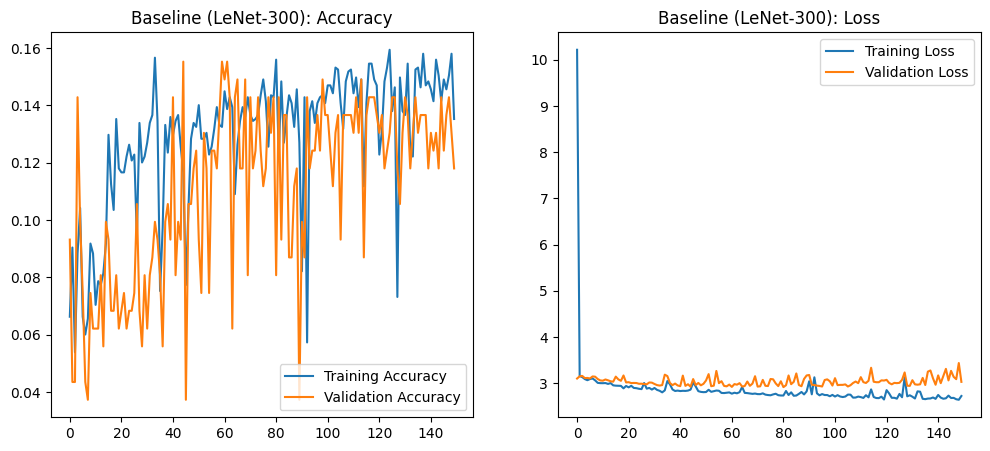

In [ ]:
# Plot the results immediately
plot_history(history_baseline, "Baseline (LeNet-300)")

From the graph we can see that the model performs better than random guessing. With 24 classes, random accuracy would be about **1/24 ≈ 4%**, while the model reaches **around 15%** accuracy on both training and validation sets. However, the validation accuracy (orange line) is very noisy and fluctuates significantly between epochs.

**LeNet-300** is a fully connected network that operates on flattened images and therefore has no notion of spatial structure. Small shifts in the input image result in completely different input representations, which limits the model’s ability to generalize spatial features.

In the loss plot, the training loss steadily decreases, while the validation loss only slightly improves at the beginning and then fluctuates without clear improvement. This indicates limited generalization and shows that the fully connected baseline is not well suited for this image classification task.

### Phase 2: Intermediate approach

**Goal:** Introduce spatial learning and fix the overfitting

**Architecture:** LeNet-5 (Convolutional Network)

**Features to Include:** Data Augmentation & Batch Normalization

**Implementation:**:
* Layers: Conv2D $\to$ MaxPool $\to$ Conv2D $\to$ MaxPool $\to$ Dense
* Augmentation: Adding the data_augmentation block (Rotation, Zoom, Color Contrast)
* Regularization: Added `layers.Dropout(0.5)` before the final layer

In [ ]:
def build_lenet5_improved(num_classes):
    model = models.Sequential([
        layers.Input(shape=(112, 112, 3)),
        layers.Rescaling(1./255),

        # 1. Data Augmentation (Addressing the "Small Dataset" issue)
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.2),

        # 2. Feature Extraction (The CNN part)
        # Block 1
        layers.Conv2D(6, (5, 5), activation='relu'),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(), # Stabilizes learning

        # Block 2
        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),

        layers.Flatten(),

        # 3. Classification (The Dense part)
        layers.Dense(120, activation='relu'),
        layers.Dropout(0.5), # Regularization (Addressing Overfitting)

        layers.Dense(84, activation='relu'),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

This architecture comes from the original LeNet-5 paper (1998) by Yann LeCun which was recommended. It was designed to recognize handwritten digits (MNIST), which are structurally similar to isolated Greek characters.

**Features:**
* Layer 1 (6 Filters): The network looks for simple features like horizontal lines, vertical lines, and simple curves. 6 filters is a small number, but sufficient for basic strokes.
* Layer 2 (16 Filters): The network combines those simple lines into complex features like corners, loops, and intersections. More filters (16) here because there are many more ways to combine lines than there are lines themselves

**Kernel size:**
* A 5x5 window is large enough to see the "stroke width" of a character. If the kernel were too small (e.g., 2x2), it might zoom in too much on the texture of the lead seal rather than the shape of the letter.

Batch Normalization is a layer that automatically "recenters" and "rescales" the data between layers. It forces the output of the previous layer to have a mean of 0 and a variance of 1.


In [ ]:
# Build and Compile
lenet5_model = build_lenet5_improved(len(class_names))

lenet5_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
# Train
print("\nStarting Phase 2 Training (CNN)...")
history_lenet5 = lenet5_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150
)


Starting Phase 2 Training (CNN)...
Epoch 1/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.0926 - loss: 4.3049 - val_accuracy: 0.0745 - val_loss: 3.1233
Epoch 2/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.1381 - loss: 3.4218 - val_accuracy: 0.0870 - val_loss: 3.0853
Epoch 3/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.1711 - loss: 3.1456 - val_accuracy: 0.0373 - val_loss: 3.1411
Epoch 4/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.1741 - loss: 3.0856 - val_accuracy: 0.1739 - val_loss: 2.9669
Epoch 5/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.2257 - loss: 2.8074 - val_accuracy: 0.0870 - val_loss: 3.0777
Epoch 6/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.2395 - loss: 2.7258 - val_accuracy: 0.1925 - val_loss: 2.8867
Epoch 7/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.2799 - loss: 2.5865 - val_accuracy: 0.2547 - val_loss: 2.6417
Epoch 8/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accu

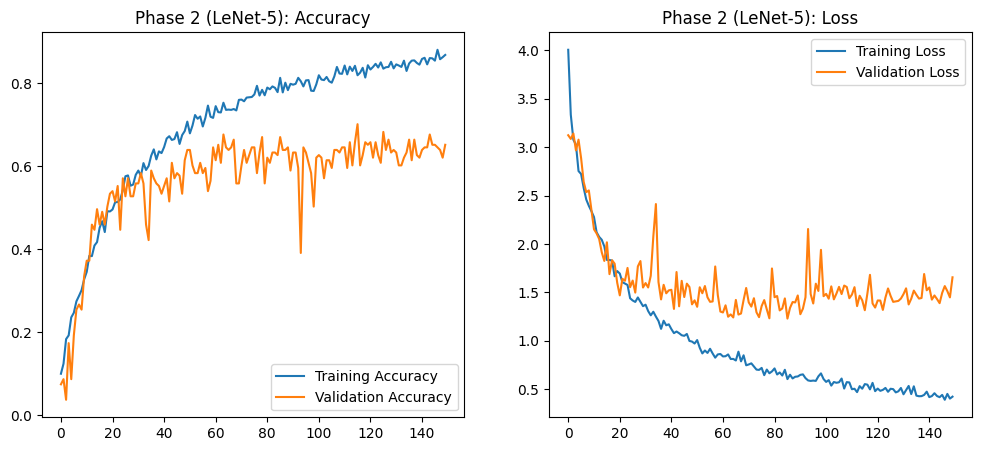

In [ ]:
# Plot the comparison
plot_history(history_lenet5, "Phase 2 (LeNet-5)")

Validation accuracy increased significantly from Phase 1 to Phase 2, reaching around **60–65%**, which confirms that the fully connected model struggled due to its inability to capture spatial structure. In contrast, the CNN successfully learns edges, curves, and strokes, resulting in a substantial performance improvement.

In the loss plot, the training loss steadily decreases, while the validation loss drops rapidly during the early epochs and then stabilizes, fluctuating around a constant value. This indicates improved generalization compared to Phase 1, although a noticeable gap between training and validation performance remains.

The validation accuracy still exhibits fluctuations, which is expected given the small validation set size (~160 images), where a few difficult samples can noticeably affect the measured performance.

### Phase 3: Upper Bound

**Goal:** Maximize performance using Transfer Learning

**Architecture:** ResNet50 (Pre-trained on ImageNet)

**Hypothesis:** "Our LeNet-5 model is learning, but it is shallow (only 2 convolutional layers). It might struggle to distinguish very similar letters (like Lambda vs. Delta). A massive network like ResNet50, pretrained on millions of images, already knows how to detect complex textures and shapes. We can 'transfer' this knowledge to our seals."

**Implementation:**
* Technique: Load `tf.keras.applications.ResNet50` with `weights='imagenet'`, freeze the base, and train only the top layers
* Optimization: Used lower learning rate (1e-4) to avoid destroying the pretrained weights



In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
  ]
)

In [ ]:
def build_resnet_model(num_classes):
    # 1. Load the Base Model (Pre-trained on ImageNet)
    # include_top=False means we chop off the final classification layer
    # so we can add our own for the Greek letters.
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(112, 112, 3)
    )

    # 2. Freeze the Base Model
    # We don't want to destroy the pre-trained patterns, so we make them non-trainable.
    base_model.trainable = False

    # 3. Build the Final Architecture
    inputs = keras.Input(shape=(112, 112, 3))

    # Apply the same augmentation
    x = data_augmentation(inputs)

    # Crucial: ResNet has specific preprocessing requirements (e.g. centering pixels)
    x = tf.keras.applications.resnet50.preprocess_input(x)

    # Pass through the frozen base model
    x = base_model(x, training=False)

    # Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Regularization
    x = layers.Dropout(0.5)(x)

    # Final Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model

In [ ]:
# Build and Compile
resnet_model = build_resnet_model(len(class_names))

# We use a lower learning rate (1e-4) for fine-tuning/transfer learning
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
print("\nStarting Phase 3 Training (ResNet)...")
# Training for 150 epochs since transfer learning can be slower to converge initially
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150
)


Starting Phase 3 Training (ResNet)...
Epoch 1/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 651s 14s/step - accuracy: 0.0410 - loss: 4.3201 - val_accuracy: 0.0497 - val_loss: 3.3187
Epoch 2/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.0593 - loss: 3.9259 - val_accuracy: 0.0621 - val_loss: 3.2276
Epoch 3/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.0575 - loss: 3.9318 - val_accuracy: 0.0683 - val_loss: 3.1423
Epoch 4/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.0717 - loss: 3.7844 - val_accuracy: 0.1056 - val_loss: 3.0758
Epoch 5/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.0995 - loss: 3.5719 - val_accuracy: 0.1118 - val_loss: 3.0232
Epoch 6/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.1004 - loss: 3.6086 - val_accuracy: 0.1180 - val_loss: 2.9668
Epoch 7/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.1140 - loss: 3.3810 - val_accuracy: 0.1180 - val_loss: 2.9373
Epoch 8/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accurac

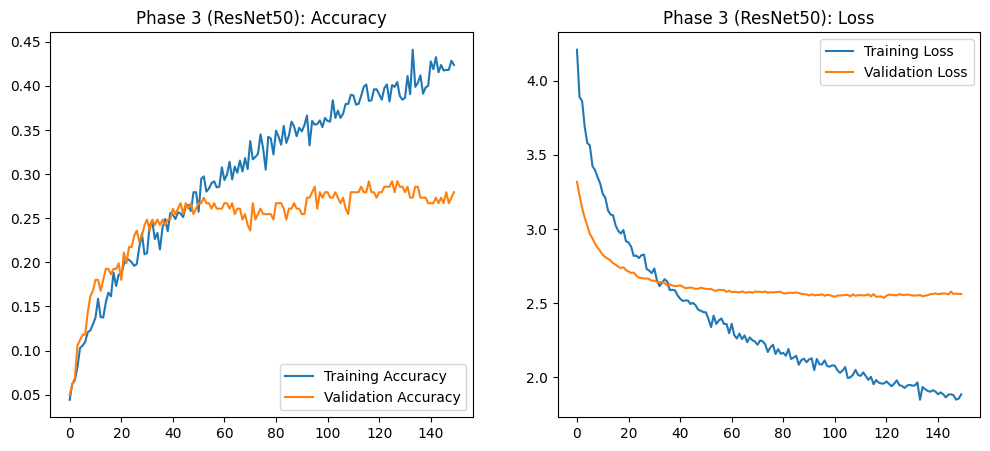

In [ ]:
# Plot Results
plot_history(history_resnet, "Phase 3 (ResNet50)")

The results for Phase 3 (**ResNet50**) show relatively low validation accuracy, stabilizing around **25–30%**, which is significantly worse than the performance achieved in Phase 2 (**LeNet-5**).

Although the training accuracy steadily increases and the training loss continues to decrease, the validation accuracy quickly plateaus and the validation loss shows only limited improvement. This indicates that the model is learning to fit the training data but struggles to generalize to unseen samples.

A likely reason for this behavior is that the **ResNet50** backbone was pre-trained on ImageNet and kept frozen during training. As a result, the model relies on features learned from natural images, which do not transfer well to grayscale images of embossed characters, limiting its effectiveness on this specialized task.

### Phase 4: Fix Fine-Tuning

To try to fix this (and get the "Upper Bound" performance), we need to unfreeze the top layers of the ResNet. This allows the model to "forget" about cats and "learn" about lead seals, while keeping the useful low-level edge detectors.

This could be treated as the final step of the journey. If this works, it usually beats LeNet-5. If it doesn't, LeNet-5 would be the champion.

In [ ]:
base_model_layer = None
for layer in resnet_model.layers:
    if "resnet" in layer.name:
        base_model_layer = layer
        break

if base_model_layer is None:
    print("Error: Could not find ResNet layer!")
else:
    print(f"Found base layer: {base_model_layer.name}")

    # 2. Unfreeze the base model
    base_model_layer.trainable = True

    # 3. Refreeze the bottom layers (keep the basic edge detectors)
    # We want to train only the top ~30 layers
    fine_tune_at = 140

    # We iterate through the LAYERS INSIDE the ResNet
    for layer in base_model_layer.layers[:fine_tune_at]:
        layer.trainable = False

    print("Unfrozen top layers of ResNet!")

    # 4. Recompile (CRITICAL: You must recompile after changing trainable status)
    resnet_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Low rate is key
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

Found base layer: resnet50
Unfrozen top layers of ResNet!


In [ ]:
# 5. Verify it worked
# This number should now be huge (e.g., 50+)
print(f"Number of trainable weights: {len(resnet_model.trainable_weights)}")

Number of trainable weights: 44


In [ ]:
# 6. Continue Training
history_fine = resnet_model.fit(
        train_ds,
        validation_data=val_ds,
        initial_epoch=history_resnet.epoch[-1],
        epochs=300
    )

Epoch 150/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.2739 - loss: 2.7659 - val_accuracy: 0.2671 - val_loss: 2.6611
Epoch 151/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.3169 - loss: 2.5029 - val_accuracy: 0.2547 - val_loss: 2.7610
Epoch 152/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.3100 - loss: 2.4496 - val_accuracy: 0.2733 - val_loss: 2.8238
Epoch 153/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.3237 - loss: 2.3546 - val_accuracy: 0.2733 - val_loss: 2.8497
Epoch 154/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.3500 - loss: 2.2800 - val_accuracy: 0.2671 - val_loss: 2.8578
Epoch 155/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.3529 - loss: 2.2851 - val_accuracy: 0.2547 - val_loss: 2.8573
Epoch 156/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.3825 - loss: 2.1880 - val_accuracy: 0.2484 - val_loss: 2.8462
Epoch 157/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.3379 - loss: 

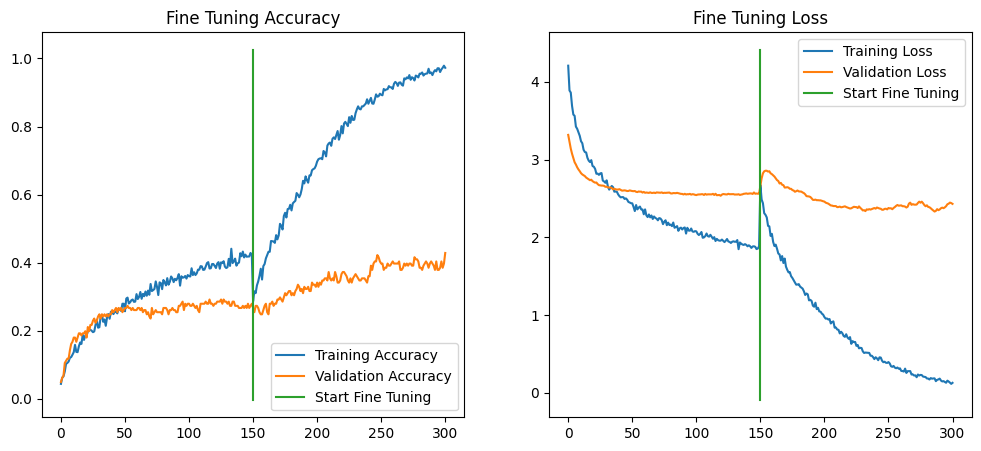

In [ ]:
# 5. Plot the Combined History
def plot_fine_tuning(original_history, fine_history):
    acc = original_history.history['accuracy'] + fine_history.history['accuracy']
    val_acc = original_history.history['val_accuracy'] + fine_history.history['val_accuracy']
    loss = original_history.history['loss'] + fine_history.history['loss']
    val_loss = original_history.history['val_loss'] + fine_history.history['val_loss']

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot([150, 150], plt.ylim(), label='Start Fine Tuning') # Mark the shift
    plt.legend(loc='lower right')
    plt.title('Fine Tuning Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.plot([150, 150], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Fine Tuning Loss')
    plt.show()

plot_fine_tuning(history_resnet, history_fine)

After enabling fine-tuning (green vertical line), both training and validation accuracy increase noticeably. The validation accuracy improves from approximately **30%** to around **40%**, indicating that unfreezing the backbone allows the model to adapt better to the target domain.

However, the gap between training and validation accuracy continues to widen, suggesting that while the model benefits from fine-tuning, overfitting remains present. The training loss decreases sharply after fine-tuning, whereas the validation loss shows only modest improvement and later stabilizes.

Overall, fine-tuning improves performance compared to the frozen ResNet, but the model still generalizes worse than the simpler **LeNet-5** architecture, highlighting that a smaller, task-specific network can be more effective for this dataset.

**Hypothesis:** We initially hypothesized that fine-tuning **ResNet50** for additional epochs would allow the model to better adapt to the Byzantine seal domain.

**Experiment:** The **ResNet50** backbone was unfrozen and fine-tuned for an extended number of epochs to evaluate whether domain-specific features could be learned.

**Observation:** As shown in the fine-tuning results, the training accuracy increased substantially, reaching over **85%**, while the validation accuracy improved only modestly, stabilizing around **40%**. At the same time, the training loss continued to decrease sharply, whereas the validation loss showed limited improvement, leading to a widening gap between the two curves.

**Conclusion:** These results indicate that despite fine-tuning, the domain gap between **ImageNet** (natural color images) and the target dataset (monochromatic embossed lead seals) remains significant. The model exhibits overfitting rather than robust generalization. Consequently, the custom **LeNet-5** architecture remains the best-performing model, achieving approximately 60% validation accuracy, demonstrating that a lightweight, task-specific network is more effective for this small and specialized dataset.

## Evaluation

**Goal:** detailed metrics and error analysis

**Metrics:** Confusion Matrix, Precision, Recall, F1-Score

In [ ]:
def final_evaluation_with_text(model, dataset, class_names, mapping):
    # 1. Get Predictions
    y_true_indices = []
    y_pred_indices = []

    print("Generating predictions...")
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_true_indices.extend(labels.numpy())
        y_pred_indices.extend(np.argmax(preds, axis=1))

    # Get the list of folder names (e.g., ['0', '1', '10', '11'...])
    folder_names = class_names

    # Convert every single prediction index to its Greek text label
    # If a mapping is missing, fallback to the folder name
    y_true_text = [mapping.get(folder_names[i], folder_names[i]) for i in y_true_indices]
    y_pred_text = [mapping.get(folder_names[i], folder_names[i]) for i in y_pred_indices]

    # Get a unique list of labels for the plot order (sorted alphabetically)
    unique_labels = sorted(list(set(y_true_text + y_pred_text)))

    # 3. Print Classification Report
    print("\n=== Classification Report ===")
    print(classification_report(y_true_text, y_pred_text, target_names=unique_labels))

    # 4. Plot Confusion Matrix
    cm = confusion_matrix(y_true_text, y_pred_text, labels=unique_labels)

    plt.figure(figsize=(16, 14)) # Increased size for readability
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right') # Rotate labels so they don't overlap
    plt.title('Confusion Matrix', fontsize=15)
    plt.show()

Generating predictions...

=== Classification Report ===
              precision    recall  f1-score   support

       Alpha       0.10      0.18      0.13        39
   Beta_Open       0.00      0.00      0.00        13
     C_Sigma       0.07      0.08      0.08        24
         Chi       0.00      0.00      0.00         5
   Croisette       0.75      0.43      0.55        14
       Delta       0.00      0.00      0.00         9
     Epsilon       0.00      0.00      0.00        21
         Eta       0.00      0.00      0.00        17
       Gamma       0.00      0.00      0.00        14
        Iota       0.20      0.37      0.26        35
       Kappa       0.00      0.00      0.00        19
      Lambda       0.00      0.00      0.00        15
 Ligature_OU       0.00      0.00      0.00        16
          Mu       0.00      0.00      0.00        10
          Nu       0.05      0.92      0.10        13
       Omega       0.00      0.00      0.00        51
         Phi       0.00 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


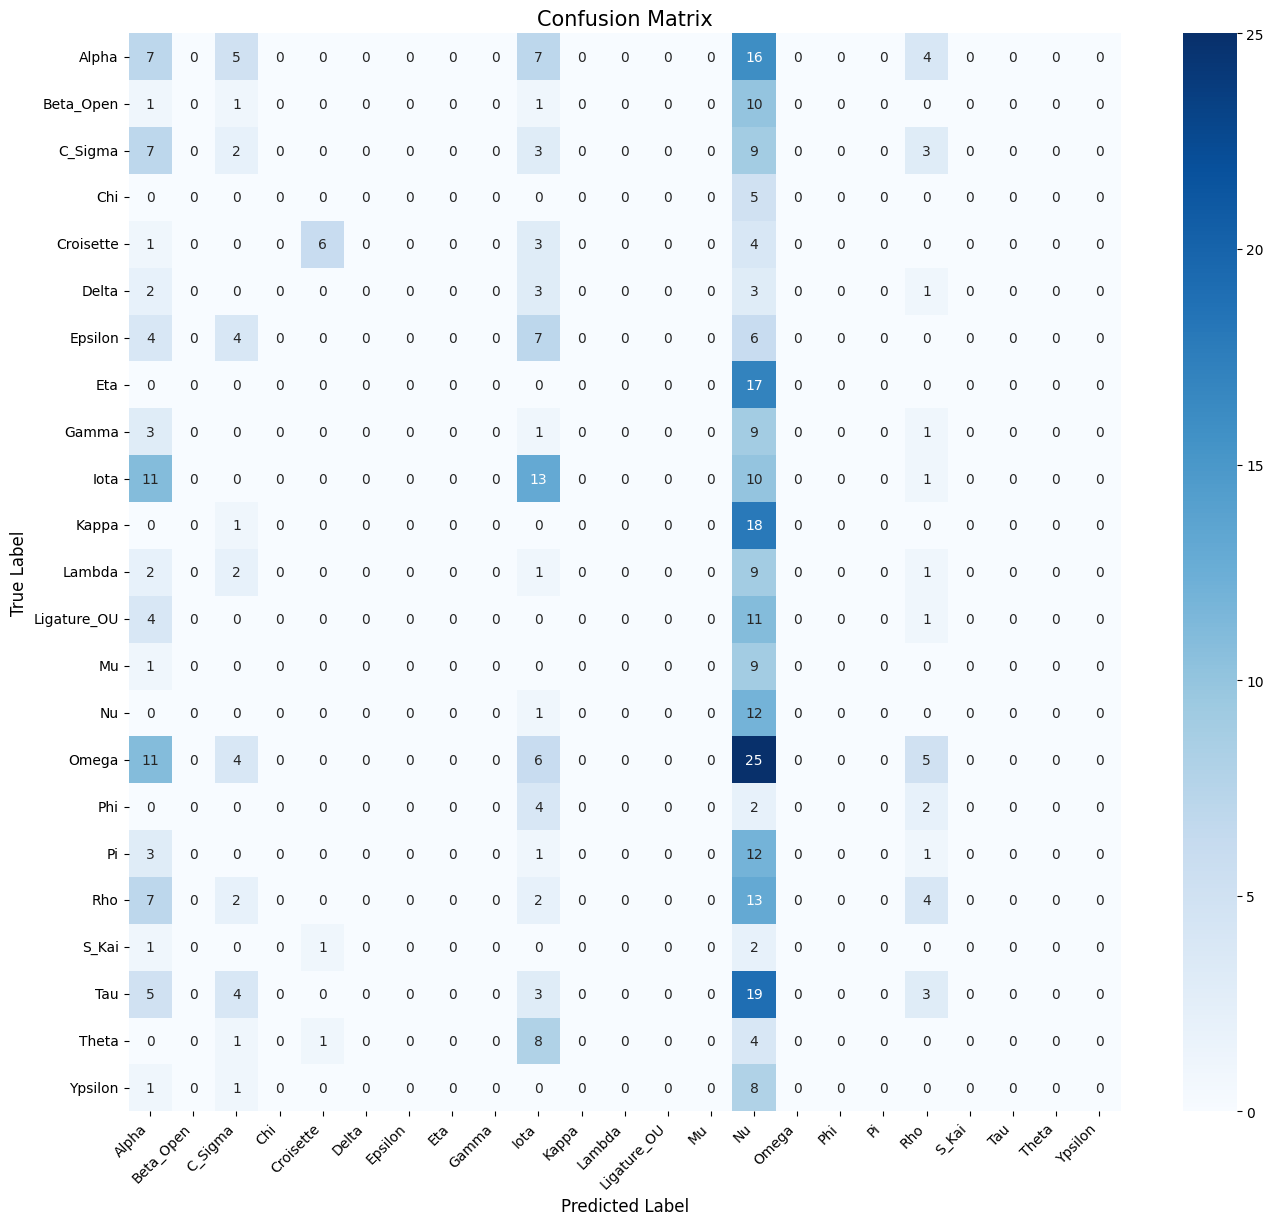

In [ ]:
# Run it (LeNet-300)
final_evaluation_with_text(baseline_model, test_ds, class_names, label_map)

Generating predictions...

=== Classification Report ===
              precision    recall  f1-score   support

       Alpha       0.81      0.64      0.71        39
   Beta_Open       0.75      0.23      0.35        13
     C_Sigma       0.67      0.92      0.77        24
         Chi       0.20      0.20      0.20         5
   Croisette       0.43      0.71      0.54        14
       Delta       0.40      0.22      0.29         9
     Epsilon       0.82      0.67      0.74        21
         Eta       0.50      0.76      0.60        17
       Gamma       0.71      0.36      0.48        14
        Iota       0.57      0.74      0.64        35
       Kappa       0.67      0.63      0.65        19
      Lambda       0.50      0.53      0.52        15
 Ligature_OU       0.33      0.31      0.32        16
          Mu       0.17      0.10      0.12        10
          Nu       0.45      0.77      0.57        13
       Omega       0.87      0.80      0.84        51
         Phi       0.45 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


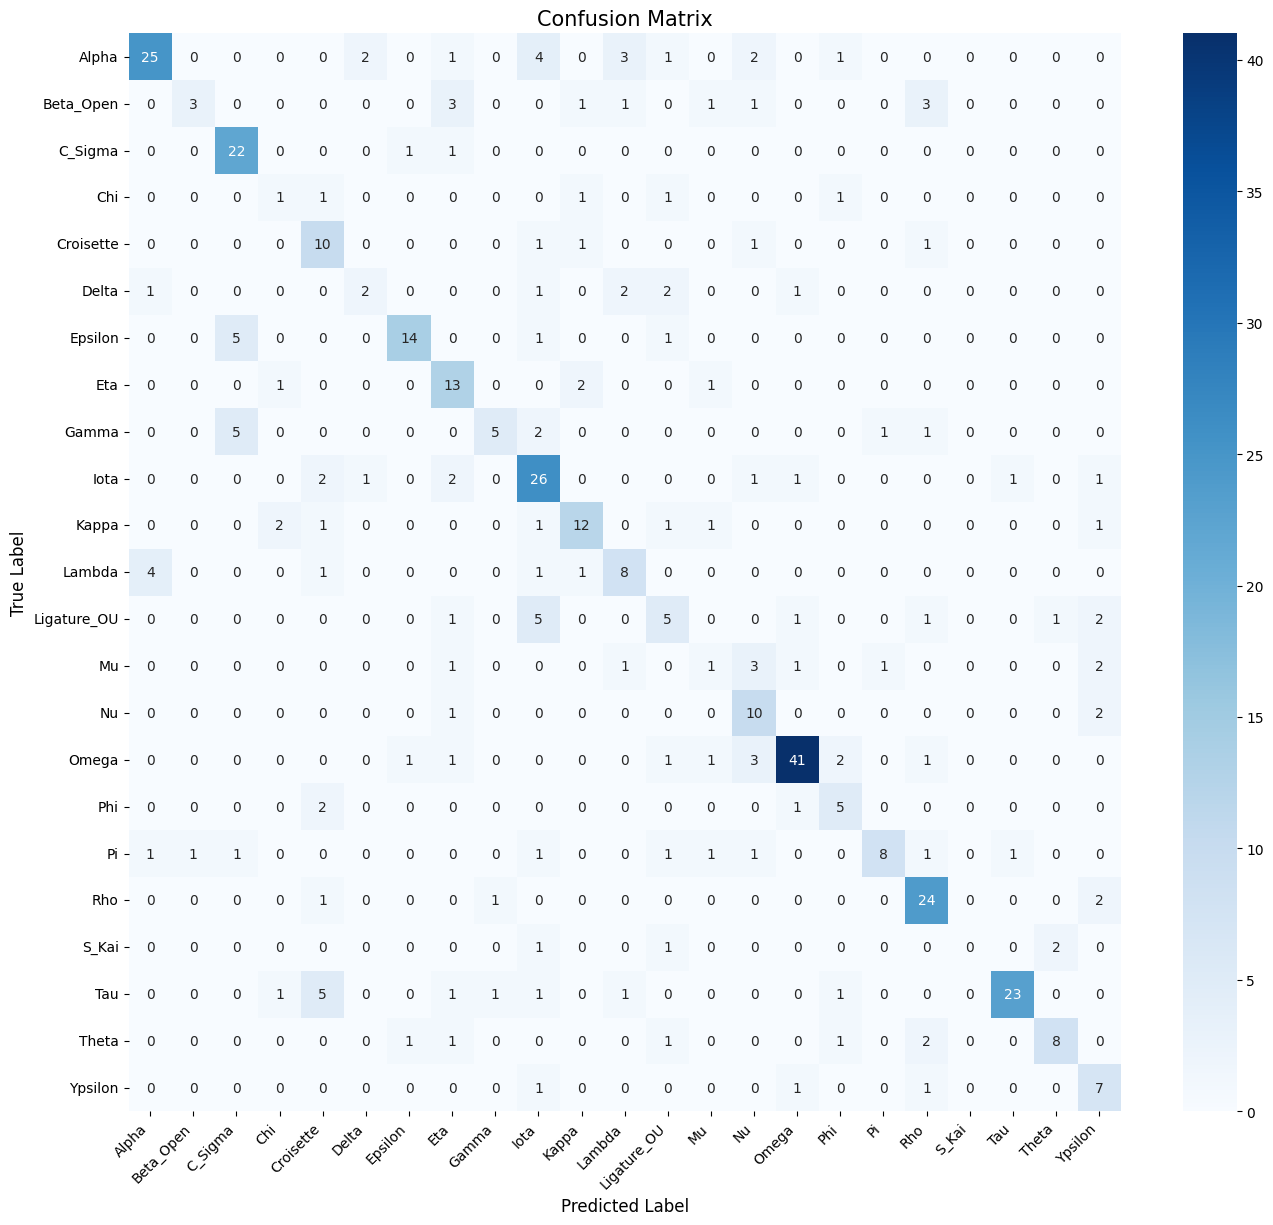

In [ ]:
# Run it (LeNet-5)
final_evaluation_with_text(lenet5_model, test_ds, class_names, label_map)

Generating predictions...

=== Classification Report ===
              precision    recall  f1-score   support

       Alpha       0.39      0.51      0.44        39
   Beta_Open       0.10      0.08      0.09        13
     C_Sigma       0.41      0.75      0.53        24
         Chi       1.00      0.20      0.33         5
   Croisette       0.40      0.43      0.41        14
       Delta       0.33      0.11      0.17         9
     Epsilon       0.40      0.38      0.39        21
         Eta       0.21      0.18      0.19        17
       Gamma       0.00      0.00      0.00        14
        Iota       0.47      0.57      0.51        35
       Kappa       0.18      0.11      0.13        19
      Lambda       0.11      0.07      0.08        15
 Ligature_OU       1.00      0.31      0.48        16
          Mu       0.14      0.10      0.12        10
          Nu       0.23      0.38      0.29        13
       Omega       0.56      0.75      0.64        51
         Phi       0.21 

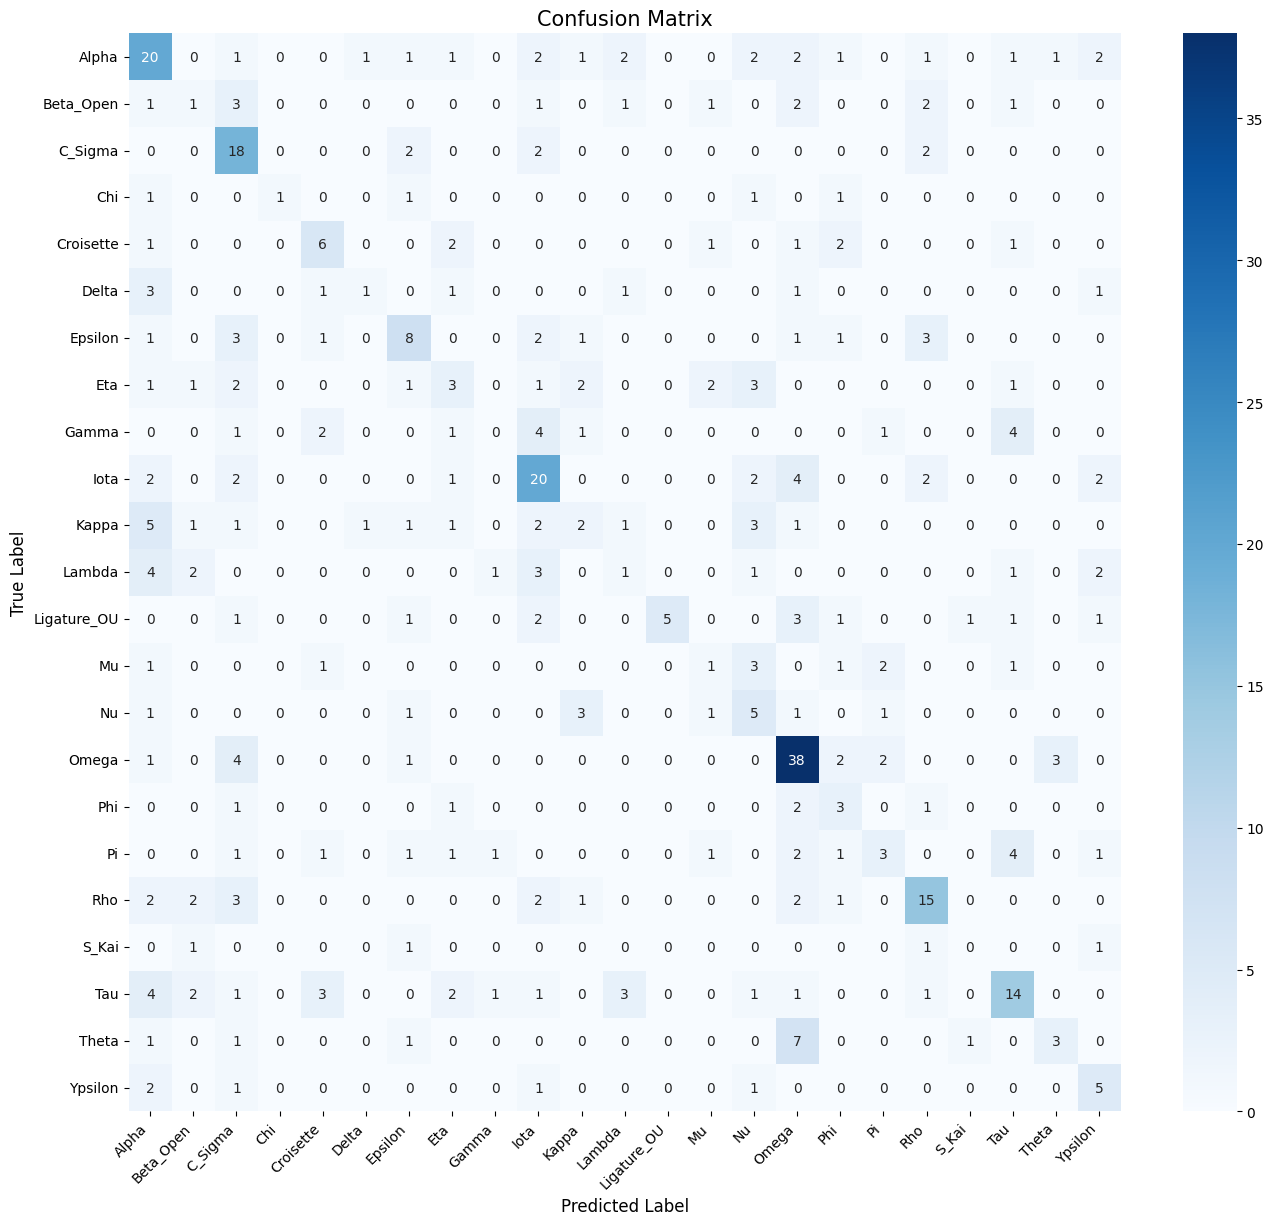

In [ ]:
# Run it (ResNet50 after fine-tuning)
final_evaluation_with_text(resnet_model, test_ds, class_names, label_map)

# Overall Comparison of Models
The three evaluated models show substantial differences in both overall performance and class-wise behavior, as reflected in the classification reports and confusion matrices.

## LeNet-300 (Fully Connected Baseline)
LeNet-300 performs poorly, achieving only 10% overall accuracy with very low macro-averaged precision, recall, and F1-score. The confusion matrix reveals severe class collapse: the model predicts only a small subset of classes (most notably Nu), while completely failing to recognize the majority of symbols. Many classes exhibit zero recall, indicating that the network never correctly predicts them.

This behavior is consistent with the limitations of fully connected networks on image data. By flattening the input, LeNet-300 loses all spatial structure, making it unable to distinguish between visually similar symbols or generalize across small spatial variations. As a result, the model effectively memorizes spurious correlations instead of learning meaningful shape-based representations.

## LeNet-5 (Convolutional Neural Network)
LeNet-5 significantly outperforms the baseline, reaching 63% overall accuracy and strong macro- and weighted-average F1-scores. The confusion matrix shows a well-defined diagonal structure, indicating consistent and balanced predictions across most classes.

High recall and precision are observed for visually distinctive symbols such as Omega, Tau, Alpha, and Rho, while more subtle or underrepresented classes (e.g., S_Kai or Mu) remain challenging. Importantly, performance is relatively stable across classes, demonstrating that the model has learned robust spatial features such as edges, curves, and stroke patterns.

These results confirm that incorporating convolutional layers and spatial inductive bias is crucial for this task. Despite its simplicity, LeNet-5 generalizes well and represents the best trade-off between model capacity and dataset size.

## ResNet50 after Fine-Tuning
After fine-tuning, ResNet50 achieves 33% accuracy, substantially improving over its frozen variant but still underperforming compared to LeNet-5. The confusion matrix indicates partial learning: a few frequent classes such as Omega, Iota, and Rho are recognized reasonably well, while many others suffer from low recall or are entirely missed.

The classification report highlights uneven class-wise performance and a relatively low macro F1-score, suggesting limited generalization. Although fine-tuning enables the network to adapt some of its features to the target domain, the large gap between training and validation performance observed earlier is reflected here in inconsistent predictions across classes.

This outcome suggests that, for this small and highly specialized dataset, the representational bias and scale of ResNet50 are not well matched to the problem. The features learned from ImageNet transfer only partially to monochromatic embossed characters, even after fine-tuning.

## Final Conclusion
Across all experiments, LeNet-5 emerges as the most effective model. It achieves the highest accuracy, the most balanced per-class performance, and the cleanest confusion matrix. These results demonstrate that for data-scarce, domain-specific image classification tasks, a lightweight, task-specific convolutional architecture can outperform much deeper pre-trained models.

This analysis underscores an important practical lesson: increasing model complexity or using state-of-the-art architectures does not guarantee better performance—especially when the dataset is small and significantly different from the source domain of pre-training.

Detected classes (folder names): ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8', '9']
Number of classes: 24
Total images available for CV: 1610

==================== FOLD 1/5 ====================
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.0692 - loss: 4.3523 - val_accuracy: 0.1025 - val_loss: 3.1332
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.1196 - loss: 3.6003 - val_accuracy: 0.1025 - val_loss: 3.1290
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.1480 - loss: 3.2109 - val_accuracy: 0.0683 - val_loss: 3.0992
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.2206 - loss: 2.9019 - val_accuracy: 0.0373 - val_loss: 3.1333
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.2709 - loss: 2.6284 - val_accuracy: 0.1366 - val_loss: 3.0014
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.2900 - loss: 2.5

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


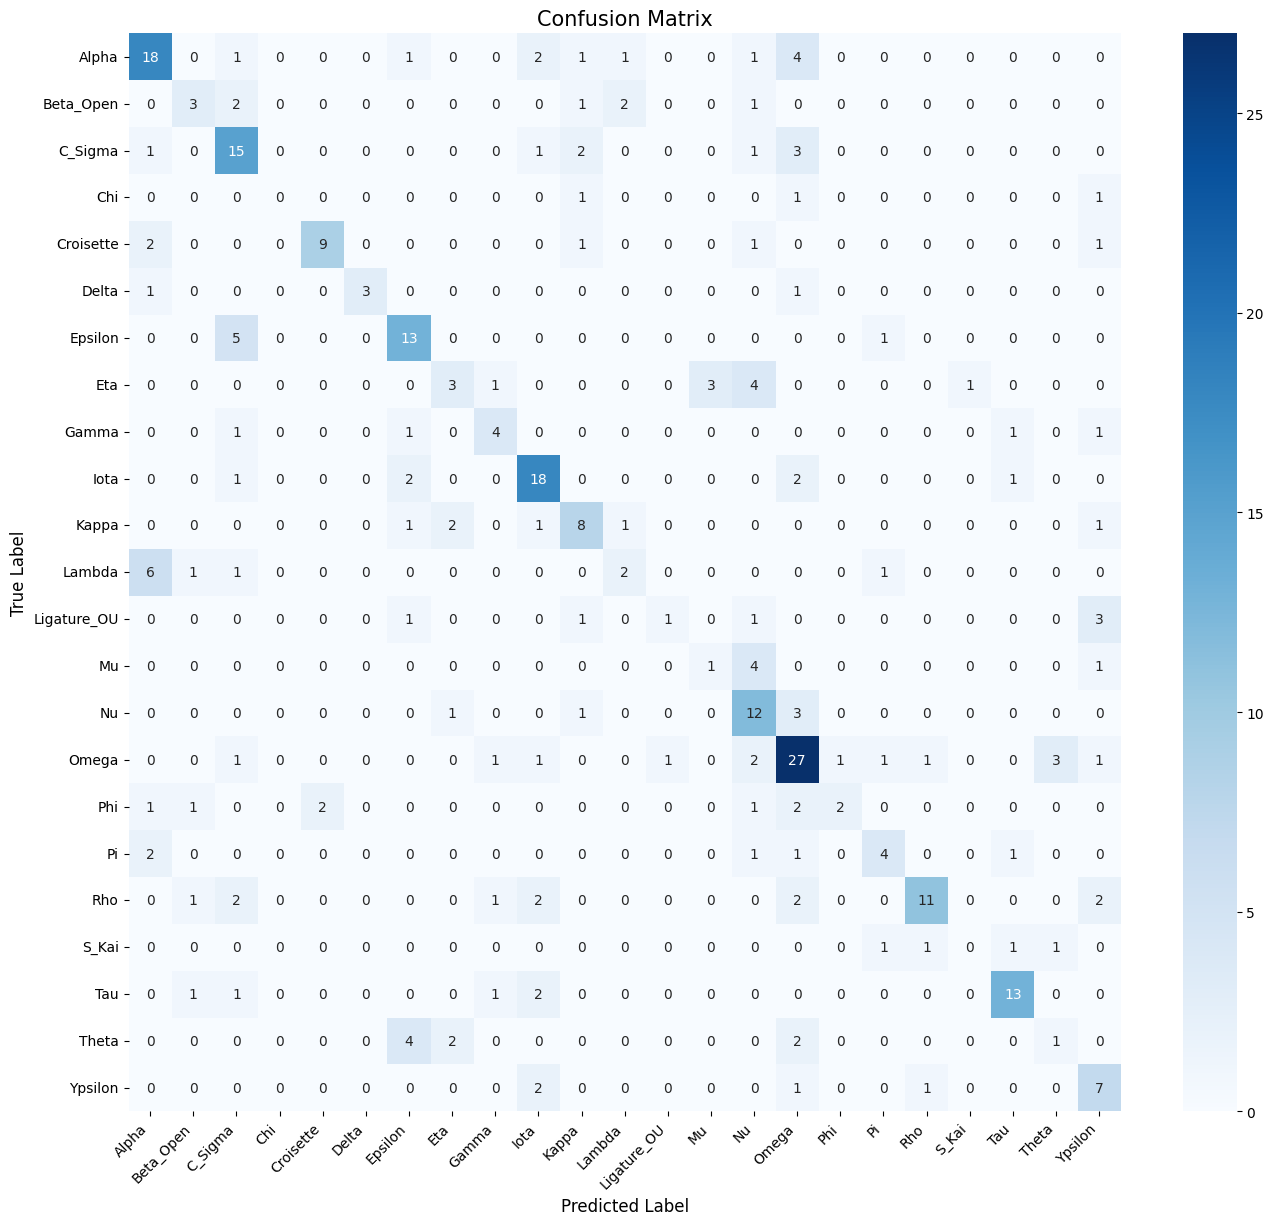

Fold 1 accuracy: 0.5373

==================== FOLD 2/5 ====================
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.0672 - loss: 4.1067 - val_accuracy: 0.0839 - val_loss: 3.1463
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.1256 - loss: 3.5032 - val_accuracy: 0.1211 - val_loss: 3.0835
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.1821 - loss: 3.0644 - val_accuracy: 0.0932 - val_loss: 3.0537
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.2017 - loss: 2.9664 - val_accuracy: 0.1087 - val_loss: 3.0434
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.1994 - loss: 2.9129 - val_accuracy: 0.0714 - val_loss: 3.0873
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.2488 - loss: 2.6882 - val_accuracy: 0.1615 - val_loss: 2.9653
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.2873 - loss: 2.5541 - val_accuracy: 0.1615 - val_loss: 3.1857
Epoch 8/30
41/41 ━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


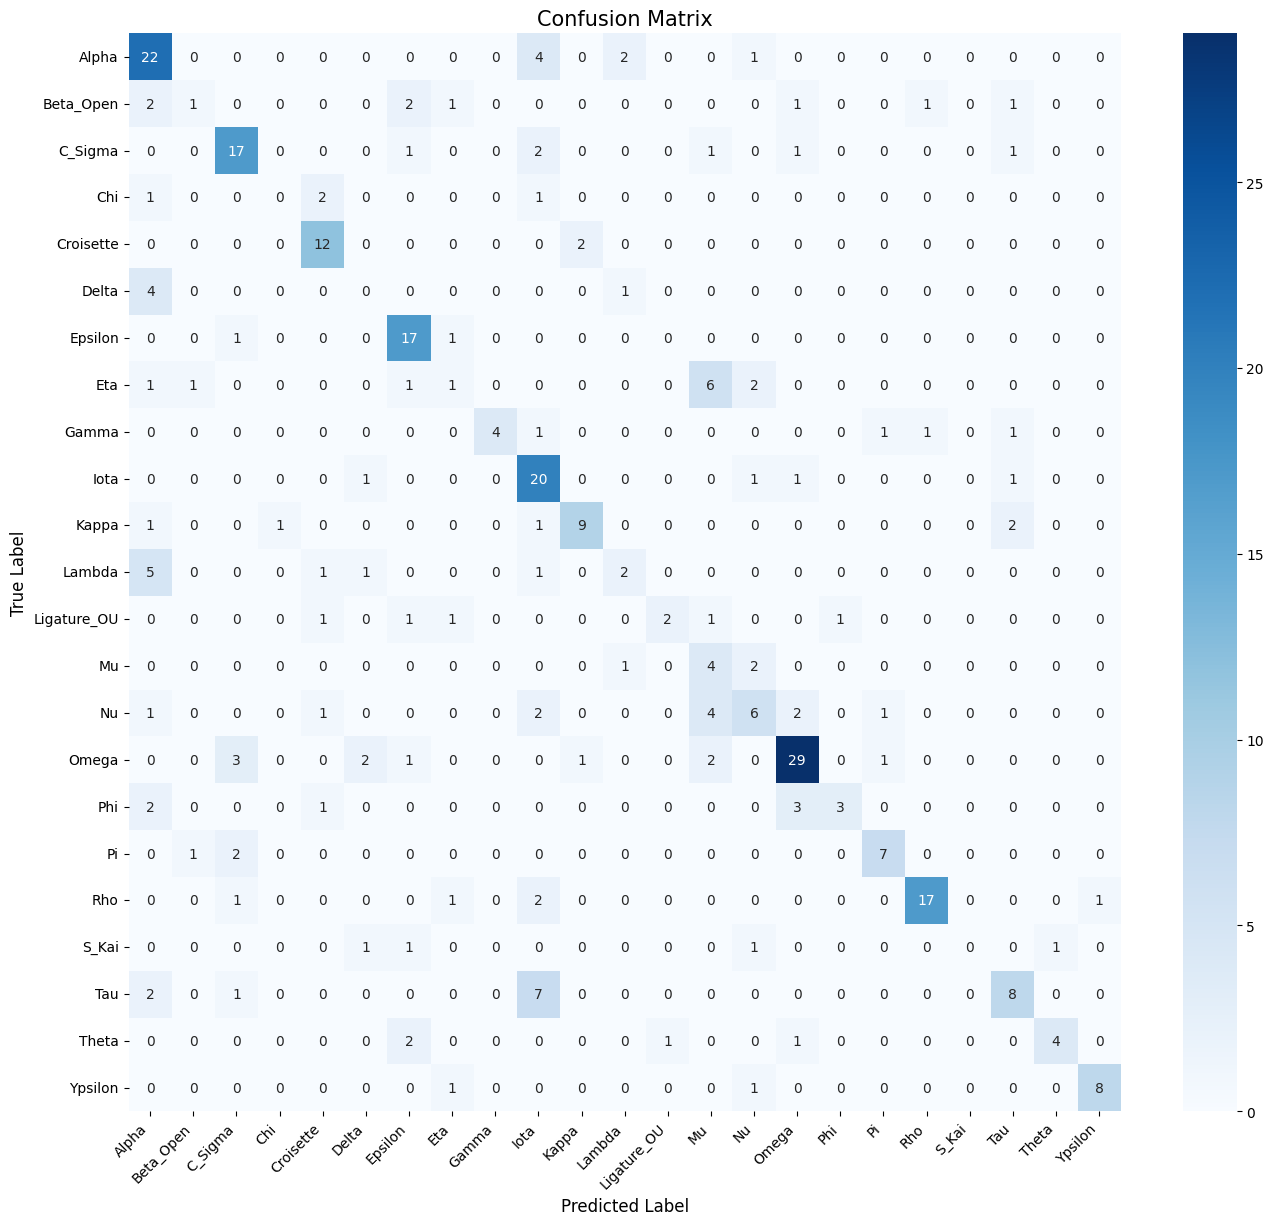

Fold 2 accuracy: 0.5994

==================== FOLD 3/5 ====================
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.0586 - loss: 4.1123 - val_accuracy: 0.0901 - val_loss: 3.1503
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.1113 - loss: 3.4257 - val_accuracy: 0.0745 - val_loss: 3.1002
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.1442 - loss: 3.1438 - val_accuracy: 0.0714 - val_loss: 3.0566
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.1940 - loss: 2.9260 - val_accuracy: 0.0839 - val_loss: 3.1304
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.2444 - loss: 2.7017 - val_accuracy: 0.0870 - val_loss: 3.0752
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.2399 - loss: 2.6636 - val_accuracy: 0.0807 - val_loss: 3.1949
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.2451 - loss: 2.5786 - val_accuracy: 0.1304 - val_loss: 2.9846
Epoch 8/30
41/41 ━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


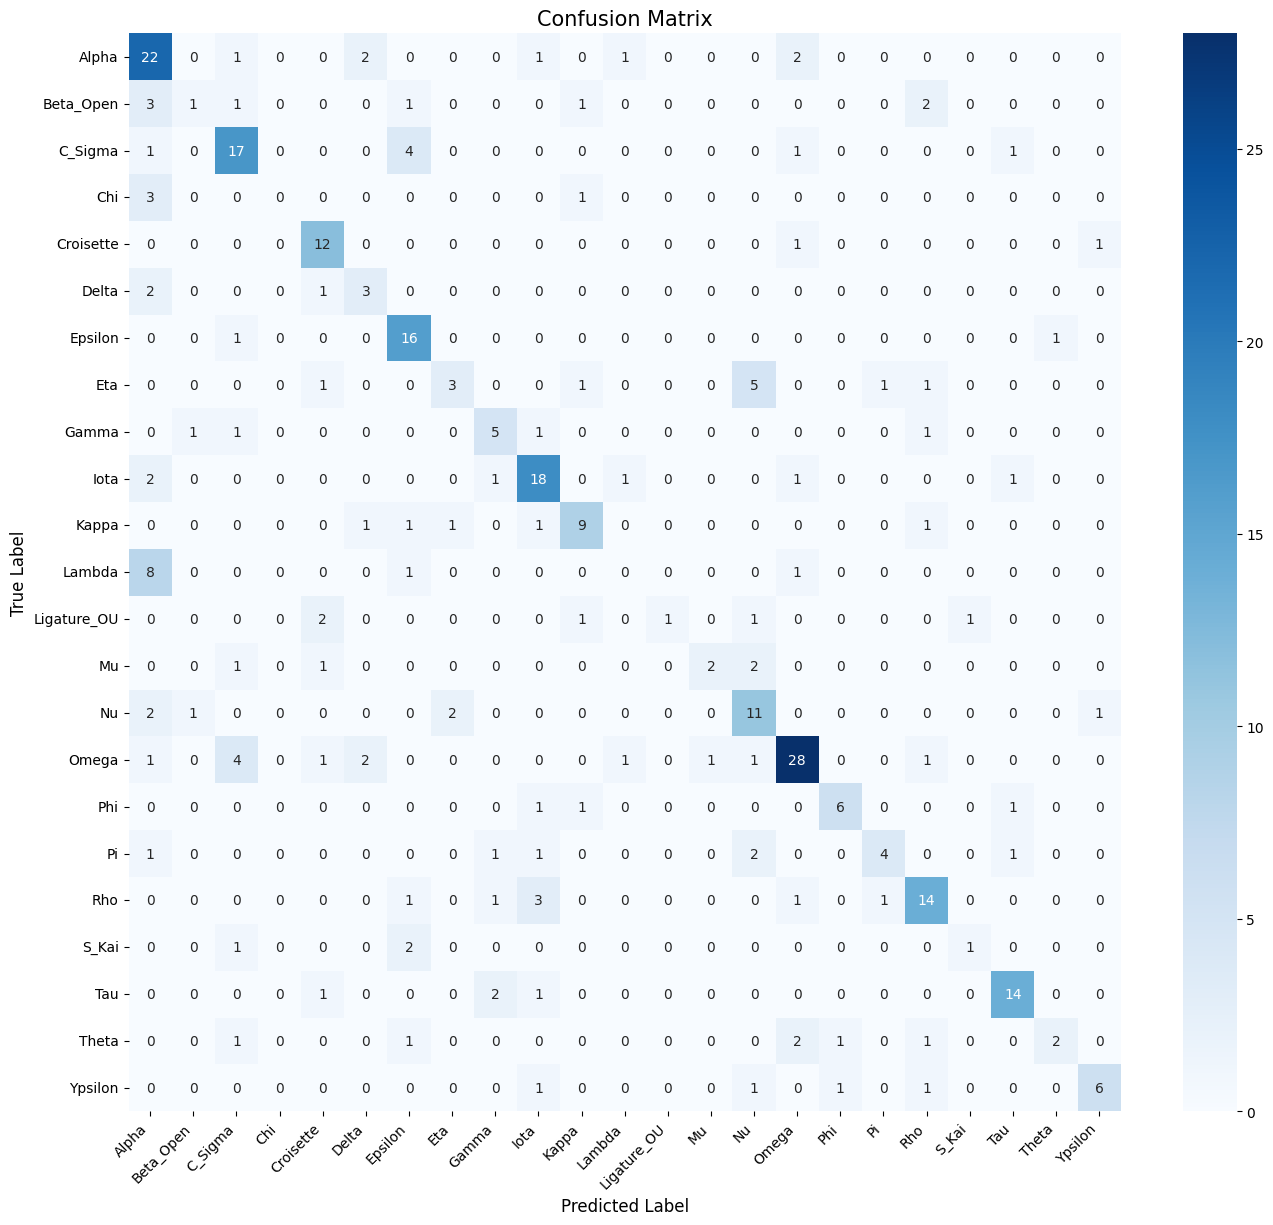

Fold 3 accuracy: 0.6056

==================== FOLD 4/5 ====================
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.0606 - loss: 3.9695 - val_accuracy: 0.0994 - val_loss: 3.1295
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.1046 - loss: 3.2306 - val_accuracy: 0.0776 - val_loss: 3.0835
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.1518 - loss: 3.0758 - val_accuracy: 0.1242 - val_loss: 3.0643
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.2310 - loss: 2.8007 - val_accuracy: 0.0963 - val_loss: 3.0991
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.2206 - loss: 2.6921 - val_accuracy: 0.1025 - val_loss: 3.1004
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.2605 - loss: 2.6314 - val_accuracy: 0.1242 - val_loss: 3.1313
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.2730 - loss: 2.5984 - val_accuracy: 0.1211 - val_loss: 3.0840
Epoch 8/30
41/41 ━━━━━━━━━━━

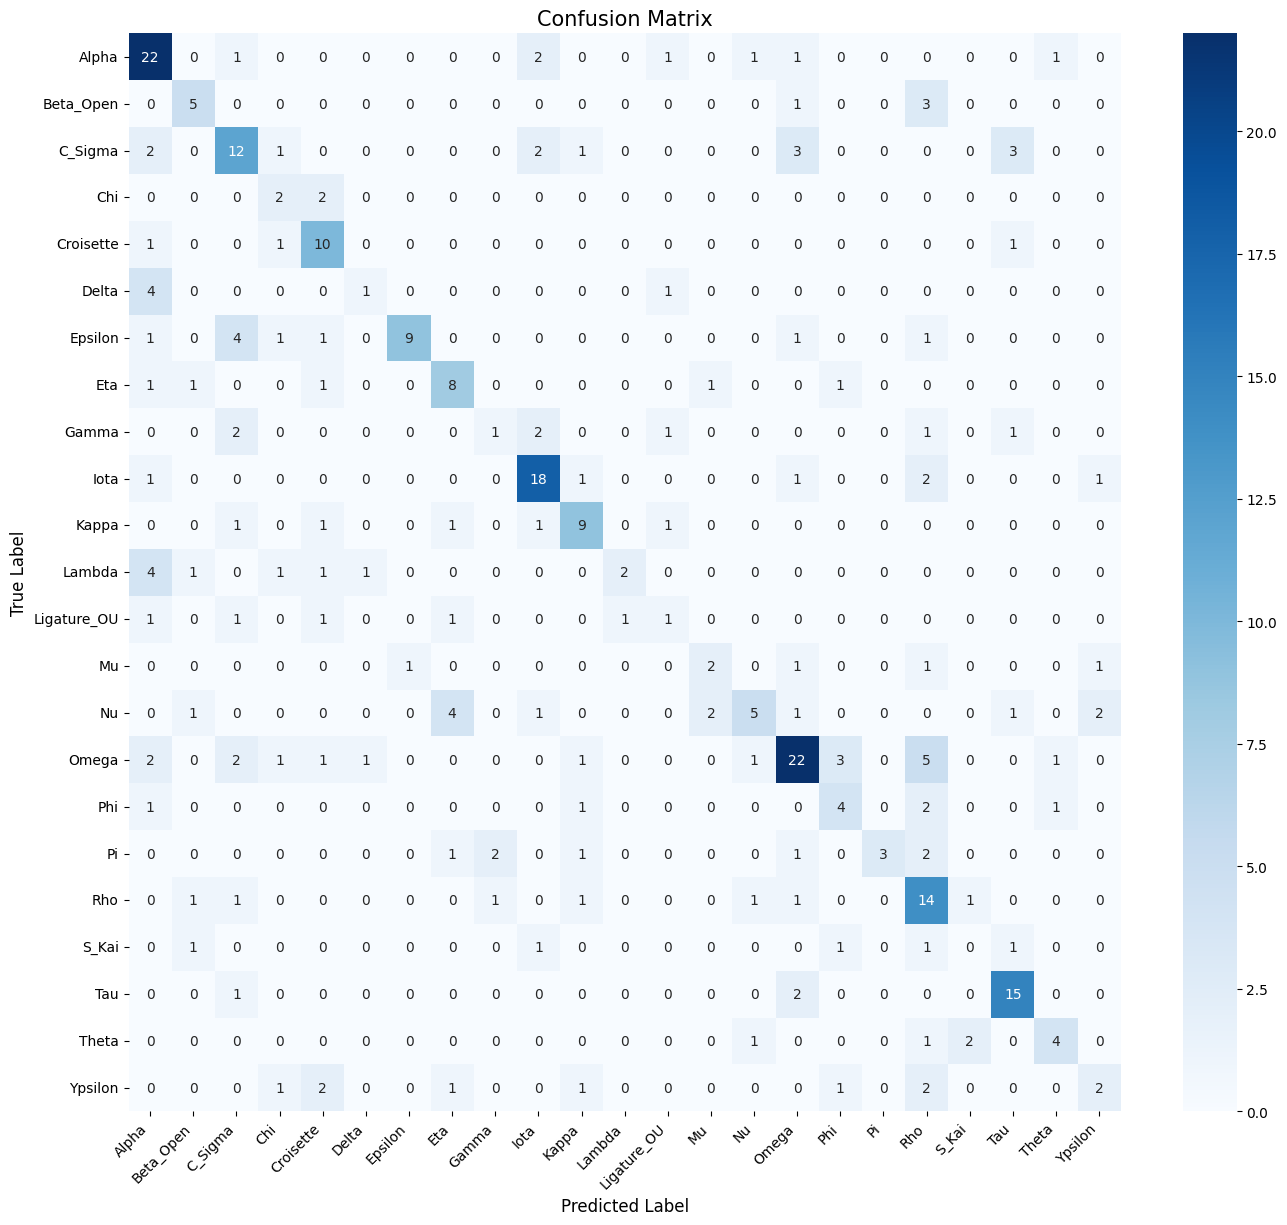

Fold 4 accuracy: 0.5280

==================== FOLD 5/5 ====================
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.0692 - loss: 4.0579 - val_accuracy: 0.0714 - val_loss: 3.1477
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.1116 - loss: 3.2701 - val_accuracy: 0.0901 - val_loss: 3.0929
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.1552 - loss: 3.0397 - val_accuracy: 0.0745 - val_loss: 3.0945
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.1953 - loss: 2.9198 - val_accuracy: 0.0901 - val_loss: 3.0792
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.2481 - loss: 2.6544 - val_accuracy: 0.0901 - val_loss: 3.1284
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.2875 - loss: 2.5425 - val_accuracy: 0.0776 - val_loss: 3.0976
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.2992 - loss: 2.3859 - val_accuracy: 0.0963 - val_loss: 2.9826
Epoch 8/30
41/41 ━━━━━━━━━━━

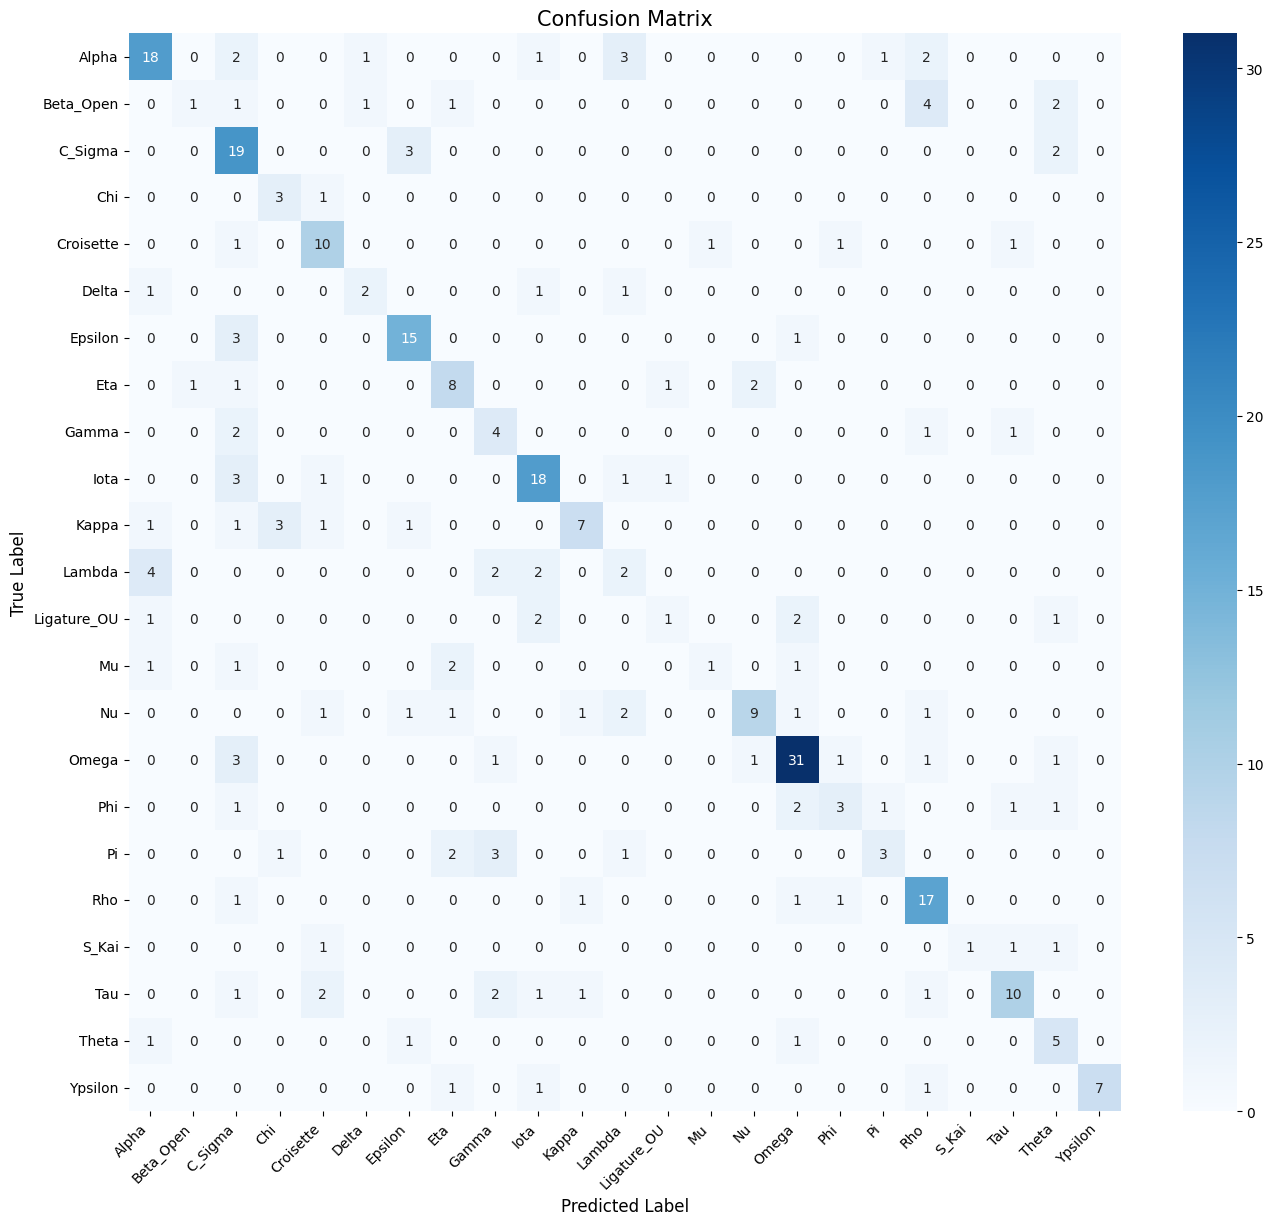

Fold 5 accuracy: 0.6056

==================== CV SUMMARY ====================
Mean accuracy over 5 folds: 0.5752
Std  accuracy over 5 folds: 0.0349
Per-fold accuracies: [0.5373, 0.5994, 0.6056, 0.528, 0.6056]


In [ ]:
# ===================== STRATIFIED K-FOLD CROSS-VALIDATION =====================
# This cell performs K-fold cross-validation on *training* directory (new_train_dir).
# Each fold:
#   1) builds a fresh model (new random weights),
#   2) trains on (K-1)/K of the data,
#   3) evaluates on 1/K of the data (held-out fold),
#   4) prints the classification report + confusion matrix.
#
# IMPORTANT:
# - Labels are integers 0..(num_classes-1), where the integer index corresponds to class_names[index].
# - We do NOT divide pixels by 255 here because model already has layers.Rescaling(1./255).

from sklearn.model_selection import StratifiedKFold

print("Detected classes (folder names):", class_names)
print("Number of classes:", len(class_names))

# -------------------------------------------------------------------
# 1) Build a flat list of samples: (file_path, label_index)
#    label_index = position of the class folder name inside class_names
# -------------------------------------------------------------------
all_file_paths = []
all_label_indices = []

for label_index, class_folder_name in enumerate(class_names):
    class_folder_path = Path(new_train_dir) / class_folder_name

    for file_path in class_folder_path.glob("*.jpg"):
        all_file_paths.append(str(file_path))
        all_label_indices.append(label_index)

all_file_paths = np.array(all_file_paths)
all_label_indices = np.array(all_label_indices, dtype=np.int32)

print(f"Total images available for CV: {len(all_file_paths)}")

# -------------------------------------------------------------------
# 2) TensorFlow input pipeline for a given set of (paths, labels)
# -------------------------------------------------------------------
def load_resize_image(path, label):
    """
    Reads an image from disk, decodes JPEG -> RGB, resizes to IMG_SIZE,
    and returns (image_tensor, label_index).

    Output image dtype: float32
    Output image range: 0..255 (rescaling happens inside the model)
    """
    image_bytes = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)
    return image, label

def build_tf_dataset(file_paths, label_indices, shuffle=False):
    """
    Creates a tf.data.Dataset from arrays of file paths and label indices.
    """
    ds = tf.data.Dataset.from_tensor_slices((file_paths, label_indices))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(file_paths), reshuffle_each_iteration=True)

    ds = ds.map(load_resize_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# -------------------------------------------------------------------
# 3) K-fold split + training/evaluation loop
# -------------------------------------------------------------------
NUM_FOLDS = 5
splitter = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

fold_accuracies = []

for fold_number, (train_indices, val_indices) in enumerate(
    splitter.split(all_file_paths, all_label_indices),
    start=1
):
    print(f"\n==================== FOLD {fold_number}/{NUM_FOLDS} ====================")

    # Build fold-specific datasets
    train_dataset = build_tf_dataset(
        all_file_paths[train_indices],
        all_label_indices[train_indices],
        shuffle=True
    )
    val_dataset = build_tf_dataset(
        all_file_paths[val_indices],
        all_label_indices[val_indices],
        shuffle=False
    )

    # Create a fresh model for this fold
    model = build_lenet5_improved(len(class_names))
    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    # Train model on this fold
    model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=30,
        verbose=1
    )

    # Detailed evaluation (report + confusion matrix)
    final_evaluation_with_text(model, val_dataset, class_names, label_map)

    # Store fold accuracy for summary stats
    _, fold_accuracy = model.evaluate(val_dataset, verbose=0)
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold_number} accuracy: {fold_accuracy:.4f}")

# -------------------------------------------------------------------
# 4) Cross-validation summary
# -------------------------------------------------------------------
print("\n==================== CV SUMMARY ====================")
print(f"Mean accuracy over {NUM_FOLDS} folds: {np.mean(fold_accuracies):.4f}")
print(f"Std  accuracy over {NUM_FOLDS} folds: {np.std(fold_accuracies):.4f}")
print("Per-fold accuracies:", [round(a, 4) for a in fold_accuracies])


Five-fold stratified cross-validation on **1,610 character** images from 24 classes achieved **a mean accuracy of 0.5752** with **a standard deviation of 0.0349**, indicating stable performance across different data splits. The macro-averaged F1-score was lower, reflecting the difficulty of recognizing underrepresented classes with limited training samples.